# DEMO: Apresentação
# MAE5871 - Análie Espectral de Séries Temporais
## Renan Avila e Vinicius Soares

## Tipos de Wavelets Disponíveis

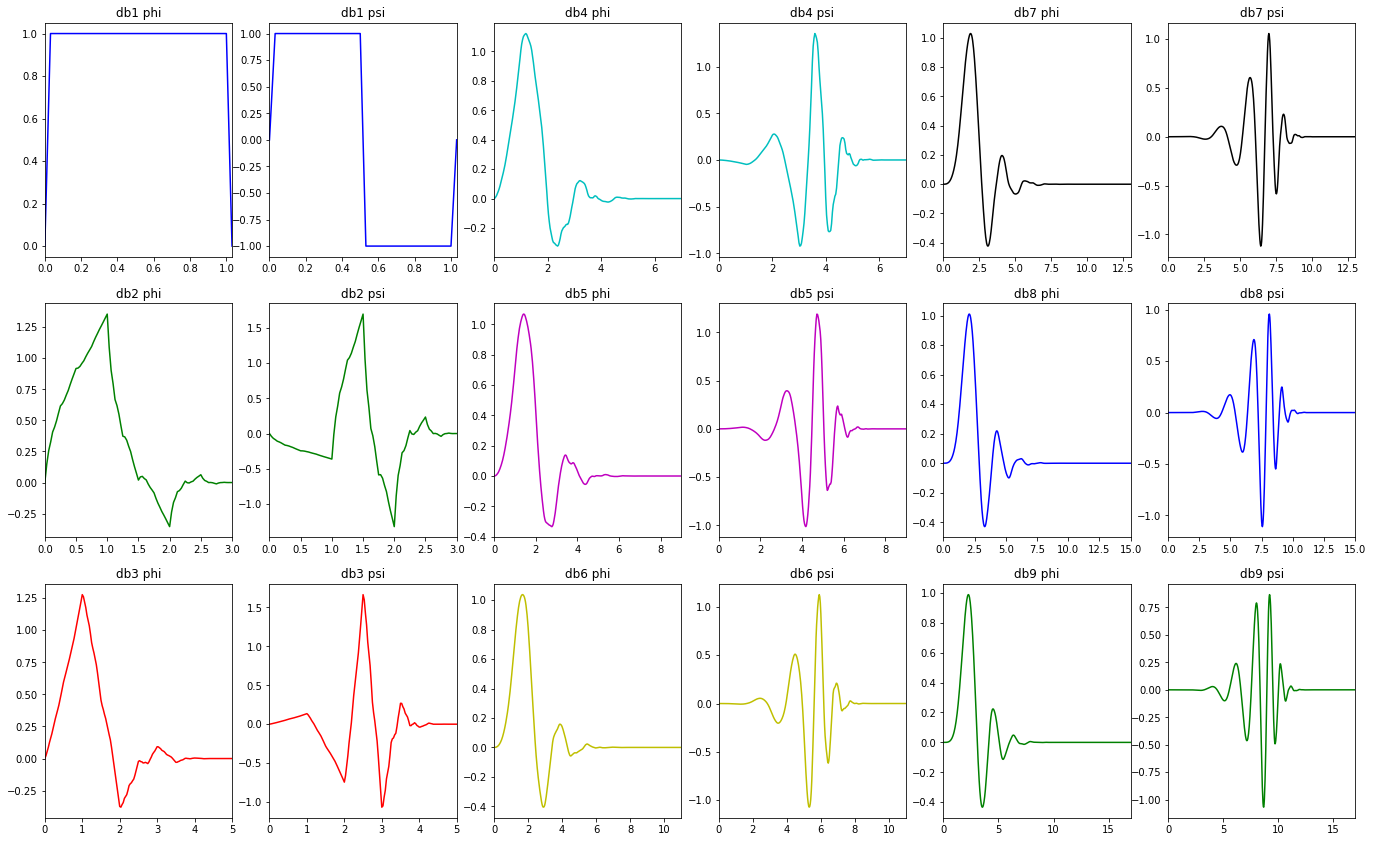

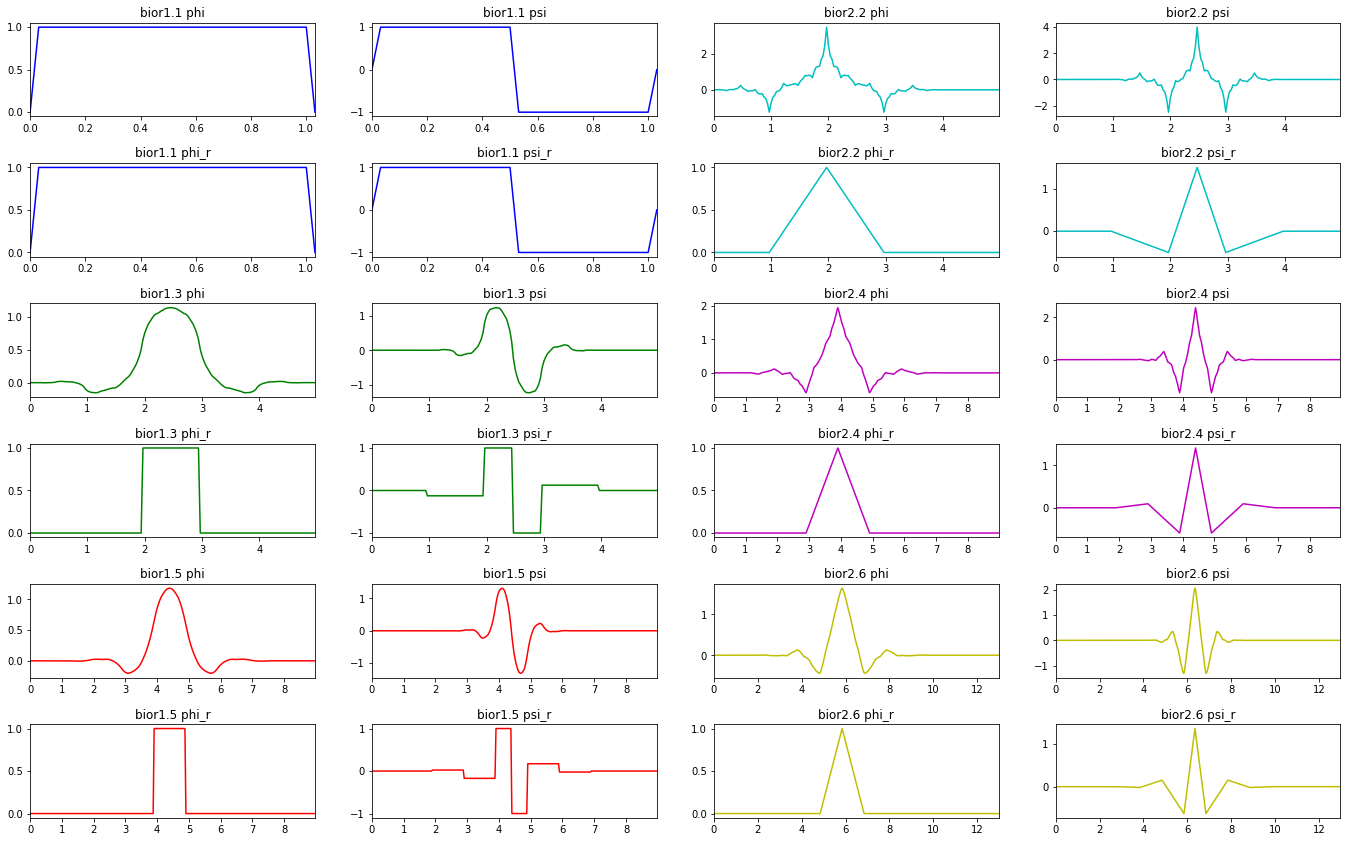

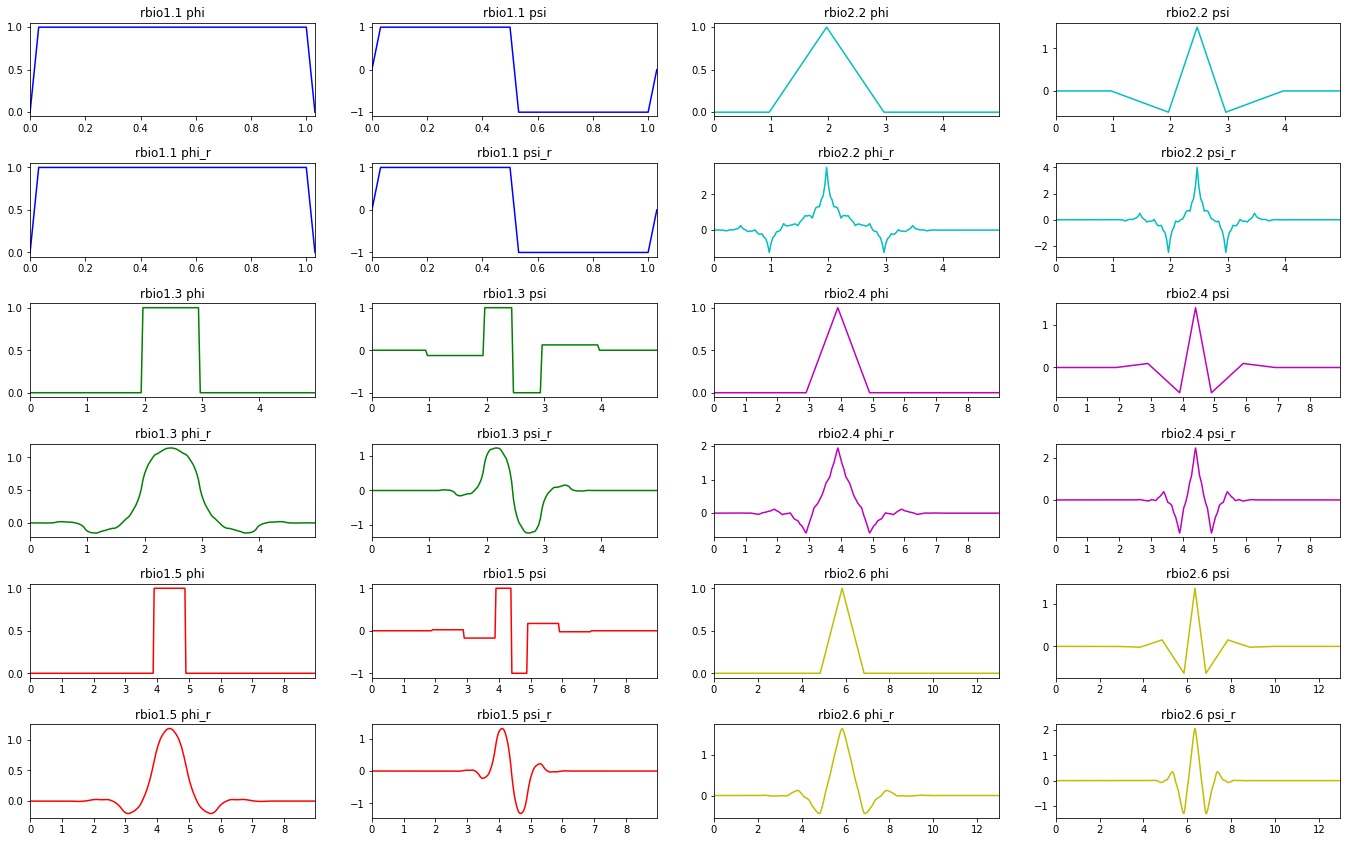

In [18]:
plot_data = [('db', (3, 3))]
second_plot_data = [('bior', (3, 2)), ('rbio', (3, 2))]

plot_family_of_wavelets(plot_data=plot_data, second_plot_data=second_plot_data)

# Sinais Artificiais
## Analisando as decomposições de Wavelets e CEEMDAN

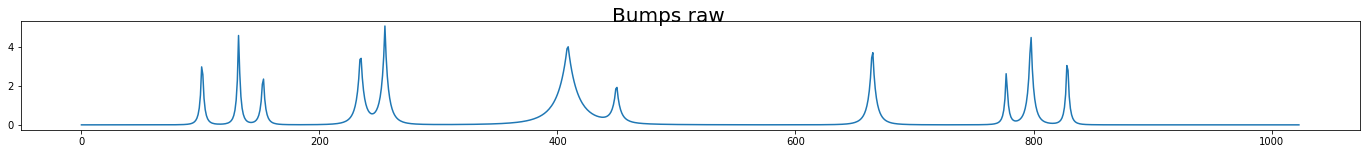

In [ ]:
artificial_signals = [
    'Blocks',
    'Bumps',
    'HeaviSine',
    'Doppler',
    'Ramp',
    'HiSine',
    'LoSine',
    'LinChirp',
    'TwoChirp',
    'QuadChirp',
    'MishMash',
    'WernerSorrows',
    'HypChirps',
    'LinChirps',
    'Chirps',
    'Gabor',
    'sineoneoverx',
    'Piece-Regular',
    'Piece-Polynomial',
    'Riemann']

wavelet_set = ['haar', 'db8', 'sym16']
wavelet_set = ['db8']
mode = pywt.Modes.smooth
artificial_signals = ['Bumps']
signal_length = 1024
plot_ceemdan = True
plot_wavelets = True 
use_ceemdan = True

index = range(signal_length)
threshold = 0.12 # Threshold for filtering
wav_name = 'db8'


std_noise = 0.25
avg_noise = 0
noise = np.random.normal(avg_noise,std_noise,signal_length) # média = 0, variância = 0.25 => ruído branco

add_noise = True

noise_component_qty = 1
remove_detail_and_approx_noise_components = True

for i in range(len(artificial_signals)):
    if artificial_signals[i] not in ['Gabor', 'sineoneoverx']:
        orig_data = pywt.data.demo_signal(name=artificial_signals[i], n=signal_length)
        simple_plot(orig_data, f'{artificial_signals[i]} raw', figsize=(24, 2))
        if add_noise == True:
            data = orig_data + noise
        if plot_ceemdan:
            name = 'CEEMDAN' if use_ceemdan else 'EMD'
            plot_ceemdan_decomp(data, f'{artificial_signals[i]} {name}', use_ceemdan, orig_data, noise_component_qty)
        if plot_wavelets:
            plot_mult_wavelet_decomp(data, wavelet_set, f'DWT - {artificial_signals[i]}', orig_data, noise_component_qty)
    else:
        orig_data = pywt.data.demo_signal(name=artificial_signals[i])
        simple_plot(orig_data, f'{artificial_signals[i]} raw', figsize=(24, 2))
        if add_noise == True:
            data = orig_data + noise
        if plot_wavelets:
            plot_mult_wavelet_decomp(data, wavelet_set, f'DWT - {artificial_signals[i]}', orig_data, noise_component_qty)
    
    line_break()

In [1]:
import itertools
import matplotlib.pyplot as plt
import random
import pywt
import pywt.data
from PyEMD import EMD, CEEMDAN
import pandas as pd
import numpy as np
from pyfiglet import Figlet
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
f = Figlet(font='slant')

In [8]:
### YLIM_DEFAULT_OFFSET = 10

def line_break():
    print(f.renderText('-------------'))
    
def lil_break():
    print(f.renderText('*********'))

def clear_plots():
    plt.clf()
    plt.close()
    
def simple_plot(data, title, figsize=(20, 4), fontsize=20):
    clear_plots()
    fig = plt.figure(figsize=figsize)
    plt.plot(data)
    fig.suptitle(title, fontsize=20)
    plt.show()
    
def plot_ceemdan_decomp(data, title, use_ceemdan=True, orig_data=None, noise_component_qty=1):
    # expected to receive single dimensional np array
    s = data

    emd_config = {"std_thr": 0.001, "range_thr": 0.005}
    emd = EMD(spline_kind='cubic', nbsym=10, **emd_config)

    ceemdan_config = {"range_thr": 0.0001, "total_power_thr": 0.001}
    ceemdan = CEEMDAN(trials=500, epsilon=2, ext_EMD=emd, parallel=True, **ceemdan_config)

    if use_ceemdan == True:
        IMFs = ceemdan(s)
    else:
        emd = EMD()
        IMFs = emd(s)
    
    name = 'CEEMDAN' if use_ceemdan == True else 'EMD'
    clear_plots()
    mse_recomp = plot_ceemdan_apart(data, IMFs, title, noise_component_qty, orig_data)
    
    lil_break()
            
    return IMFs
    
def plot_ceemdan_apart(data, IMFs, title='', noise_component_qty=1, orig_data=None):
    clear_plots()
    rows = 8
    cols = 2
    fig = plt.figure(figsize=(24, 12))
    fig.subplots_adjust(hspace=0.6, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.96)
    colors = itertools.cycle('bgrcmyk')

    j = 1
    ax_main = fig.add_subplot(rows, 1, j)
    ax_main.set_title(title)
    ax_main.plot(data)
    
    j += 1
    for k in range(cols*rows):
        if j < len(IMFs)+2:
            j += 1
            color = next(colors)
            ax = fig.add_subplot(rows, cols, j)
            ax.set_title(title + f' component {j-2}')
            ax.plot(IMFs[j-3], color)
    
    recomp = recompose_ceemdan_without_noise(IMFs,noise_component_qty)
    
    ax = fig.add_subplot(rows, 1, rows-1)
    ax.set_title(title + f'Denoised Recomposed qty = {noise_component_qty}')
    ax.plot(recomp, color)
        
    plt.show()
    mse_recomp = 0
    if orig_data is not None:
        mse_recomp = mse_numpy(recomp, orig_data)
    print(f'Recomposição {name} recomp/data | MSE = {mse_numpy(recomp, data)}')
    
    print(f'noise added data/orig_data mse = {mse_numpy(data, orig_data)}')
    
    print(f'Recomposição {name} recomp/orig_data | MSE = {mse_recomp}')
    
    print(f'Melhora: {np.abs((mse_recomp/mse_numpy(data, orig_data))-1)*100}%')
    
    return mse_recomp
    
def mse_numpy(data_1, data_2):
    return np.square(np.subtract(data_1,data_2)).mean() 
            
def recompose_ceemdan_without_noise(IMFs, noise_component_qty=1):
    IMFsX = IMFs[noise_component_qty:]
    return IMFsX.sum(axis=0)
    
def plot_coeffs(data, w, title, level, use_dwt=True):
    clear_plots()
    """Show dwt or swt coefficients for given data and wavelet."""
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []

    if use_dwt:
        for i in range(5):
            (a, d) = pywt.dwt(a, w, mode)
            if len(a) > 1:
                ca.append(a)
                cd.append(d)
    else:
        coeffs = pywt.swt(data, w, level)  # [(cAn, cDn), ..., (cA1, cD1)]
        for a, d in reversed(coeffs):
            ca.append(a)
            cd.append(d)

    fig = plt.figure(figsize=(20, 12))
    ax_main = fig.add_subplot(len(ca) + 1, 1, 1)
    ax_main.set_title(title, fontsize=14)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, x in enumerate(ca):
        ax = fig.add_subplot(len(ca) + 1, 2, 3 + i * 2)
        ax.plot(x, 'r')
        if i == 0:
            ax.set_title("Approximation coefficients", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        if use_dwt:
            ax.set_xlim(0, len(x) - 1)
        else:
            ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

    for i, x in enumerate(cd):
        ax = fig.add_subplot(len(cd) + 1, 2, 4 + i * 2)
        ax.plot(x, 'g')
        if i == 0:
            ax.set_title("Detail coefficients", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        # Scale axes
        ax.set_xlim(0, len(x) - 1)
        if use_dwt:
            ax.set_ylim(min(0, 1.4 * min(x)), max(0, 1.4 * max(x)))
        else:
            vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
            ax.set_ylim(min(0, 2 * min(vals) if len(vals) > 0 else -YLIM_DEFAULT_OFFSET), max(0, 2 * max(vals)) if len(vals) > 0 else YLIM_DEFAULT_OFFSET)
    
def plot_mult_wavelet_decomp(data, wavelet_set=['haar','db8'], title='', orig_data=None, noise_component_qty=1):
    for wav_name in wavelet_set:
        plot_wavelet_decomp(data, wav_name, f'{title} - {wav_name}', orig_data, noise_component_qty)
        wavelet_denoise(data, wav_name, orig_data)
        lil_break()
        
def numpy_fillna(data):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])
    min_length = min(lens)
    if min_length > signal_length:
        min_length = signal_length
    
    new_data = []
    for i in data:
        new_data += [i[:min_length]]

    out = np.asarray(new_data)
    return out
    
def plot_wavelet_decomp(data, w, title, orig_data=None, noise_component_qty=1):
    clear_plots()
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure(figsize=(20, 12))
    fig.subplots_adjust(hspace=0.6, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.92)
    ax_main = fig.add_subplot(len(rec_a) + 2, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 2, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Approximation Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 2, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Detail Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
    
    rec_a = np.asarray(rec_a)
    rec_d = np.asarray(rec_d)
    
    rec_d = rec_d[noise_component_qty:]
    if remove_detail_and_approx_noise_components:
        rec_a = rec_a[noise_component_qty:]
    
    all_rec = np.append(rec_a, rec_d, axis=0)
    
    all_rec = numpy_fillna(all_rec)
    
    all_rec = all_rec.sum(axis=0)
    
    ax = fig.add_subplot(len(rec_a) + 2, 1, len(rec_a) + 2)
    ax.set_title("Denoised Recomposition DWT", fontsize=14)
    ax.plot(all_rec, 'b')
    
    plt.show()
    
#     mse_recomp = mse_numpy(all_rec, data)
#     print(f'Recomposição DWT recomp/data | MSE = {mse_recomp}')
    
#     if orig_data is not None:
#         mse_recomp = mse_numpy(all_rec, orig_data)
#         print(f'Recomposição DWT recomp/orig_data | MSE = {mse_numpy(all_rec, orig_data)}')
    
#     print(f'noise added mse data/orig_data = {mse_numpy(data, orig_data)}')
    
#     a = mse_numpy(data, orig_data)
#     b = mse_numpy(all_rec, orig_data)
#     print(f'Melhora: {np.abs(a/b-1)*100}%')
    
    
def wavelet_denoise(data, wav_name, orig_data):

    # Create wavelet object and define parameters
    w = pywt.Wavelet(wav_name)
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    # maxlev = 2 # Override if desired
    print("maximum level is " + str(maxlev))

    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, wav_name, level=maxlev)

    #cA = pywt.threshold(cA, threshold*max(cA))
    plt.figure(figsize=(20, 12))
    for i in range(1, len(coeffs)):
        plt.subplot(maxlev, 1, i)
        plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        plt.plot(coeffs[i])

    datarec = pywt.waverec(coeffs, wav_name)

    mintime = 0
    maxtime = len(index)

    plt.figure(figsize=(20,12))
    plt.subplot(3, 1, 1)
    plt.plot(index[mintime:maxtime], data[mintime:maxtime])
    plt.title("Noise Added signal")
    plt.subplot(3, 1, 2)
    plt.plot(index[mintime:maxtime], datarec[mintime:maxtime])
    plt.title("De-noised signal using wavelet thresholding")
    plt.subplot(3, 1, 3)
    plt.plot(index[mintime:maxtime], orig_data[mintime:maxtime])
    plt.title("Original signal")

    plt.tight_layout()
    plt.show()

    print(f'noise added data/orig_data mse = {mse_numpy(data, orig_data)}')
    print(f'mse recomp/orig_data = {mse_numpy(datarec, orig_data)}')
    print(f'mse recomp/data = {mse_numpy(datarec, data)}')
    print(f'Melhora: {np.abs((mse_numpy(data, orig_data)/mse_numpy(datarec, orig_data))-1)*100}%')
    